<a href="https://colab.research.google.com/github/empriselab/social-dining/blob/main/src/models/TCN_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# Dependency - TCN
!pip install keras-tcn --no-dependencies  # without the dependencies if you already have TF/Numpy.
# This might be useful for hyperparameter tuning:
# https://github.com/philipperemy/keras-tcn#how-do-i-choose-the-correct-set-of-parameters-to-configure-my-tcn-layer

# Dependency - for model plotting
!git clone https://github.com/jancio/plot_model.git
!cd plot_model && python setup.py install

fatal: destination path 'plot_model' already exists and is not an empty directory.
running install
running bdist_egg
running egg_info
writing plot_model.egg-info/PKG-INFO
writing dependency_links to plot_model.egg-info/dependency_links.txt
writing top-level names to plot_model.egg-info/top_level.txt
adding license file 'LICENSE'
writing manifest file 'plot_model.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/plot_model
copying build/lib/plot_model/__init__.py -> build/bdist.linux-x86_64/egg/plot_model
copying build/lib/plot_model/plot_model.py -> build/bdist.linux-x86_64/egg/plot_model
byte-compiling build/bdist.linux-x86_64/egg/plot_model/__init__.py to __init__.cpython-37.pyc
byte-compiling build/bdist.linux-x86_64/egg/plot_model/plot_model.py to plot_model.cpython-37.pyc
creating build/bdist.linux-x86_64/egg/EGG-INFO
copying plot_model.egg-i

# Inputs (same for all models below)

In [14]:
from tcn import TCN
from tensorflow.keras import Model
from tensorflow.keras.utils import set_random_seed, plot_model
from tensorflow.keras.layers import Dense, Input, concatenate

from plot_model.plot_model import plot_model as color_plot_model


# Please remove this if you already set the seed elsewhere
set_random_seed(37)

# Feature counts
num_audio_features = 1
num_video_features = 256 # openpose is 252, gaze is 2, head position is 2
num_scene_video_features = 1024
num_time_features = 1
num_count_features = 1

# Window size (number of samples at 30 FPS)
window_size = 180

target_audio_input = Input(shape=(window_size, num_audio_features), name='target_audio_input')
target_video_input = Input(shape=(window_size, num_video_features), name='target_video_input')

left_audio_input = Input(shape=(window_size, num_audio_features), name='left_audio_input')
left_video_input = Input(shape=(window_size, num_video_features), name='left_video_input')

right_audio_input = Input(shape=(window_size, num_audio_features), name='right_audio_input')
right_video_input = Input(shape=(window_size, num_video_features), name='right_video_input')

scene_video_input = Input(shape=(num_scene_video_features), name='scene_video_input')
time_input = Input(shape=(num_time_features), name='time_input')
count_input = Input(shape=(num_count_features), name='count_input')

inputs = [
    target_audio_input, target_video_input,
    left_audio_input, left_video_input,
    right_audio_input, right_video_input,
    scene_video_input, 
    time_input,
    count_input
]


# Model 1: global TCN

Model: "TCN global model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 target_audio_input (InputLayer  [(None, 180, 1)]    0           []                               
 )                                                                                                
                                                                                                  
 target_video_input (InputLayer  [(None, 180, 256)]  0           []                               
 )                                                                                                
                                                                                                  
 left_audio_input (InputLayer)  [(None, 180, 1)]     0           []                               
                                                                                   

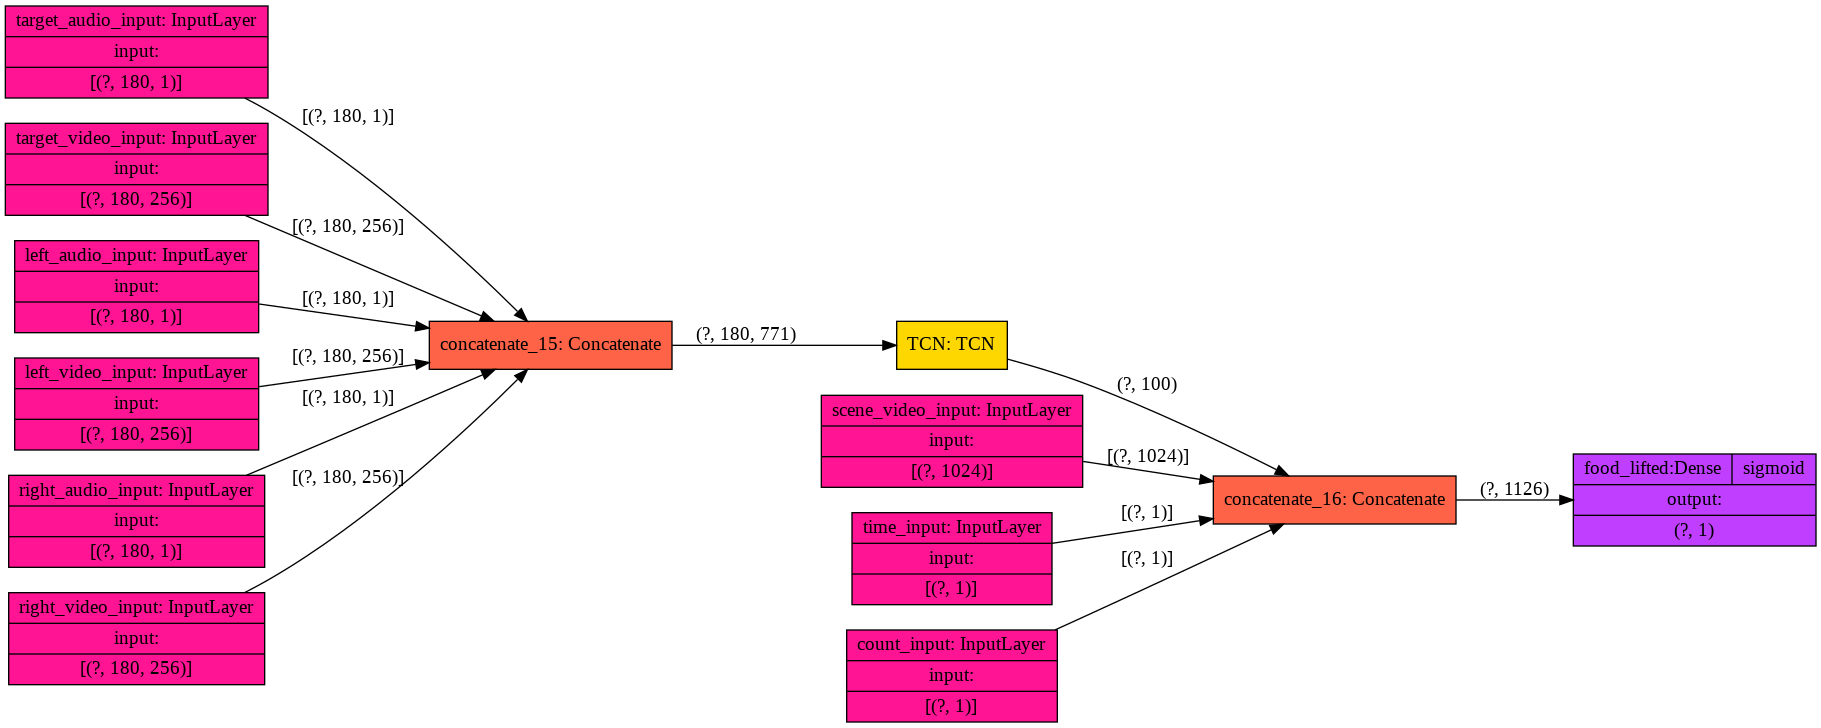

In [15]:
x = concatenate([
    target_audio_input, target_video_input,
    left_audio_input, left_video_input,
    right_audio_input, right_video_input,
    # scene_video_input
])
tcn_global = TCN(
    nb_filters=100,             # The number of filters to use in the convolutional layers. Would be similar to units for LSTM. Can be a list.
    kernel_size=7,              # The size of the kernel to use in each convolutional layer.
    nb_stacks=1,                # The number of stacks of residual blocks to use.
    dilations=(1, 2, 4, 8),     # We want window_size (180) =< receptive_field (181) = 1 + 2*(kernel_size - 1)*nb_stacks*sum(dilations)
    padding='causal',           # Keep causal for a causal network
    use_skip_connections=True,
    dropout_rate=0.05,
    return_sequences=False,
    activation='relu',
    kernel_initializer='he_normal',
    use_batch_norm=False,
    use_layer_norm=False,
    use_weight_norm=False,
    name='TCN'
)
x = concatenate([ tcn_global(x), scene_video_input, time_input, count_input ])

outputs = Dense(1, activation='sigmoid', name='food_lifted')(x)
model = Model(inputs, outputs, name='TCN global model')
model.summary()

# Plot
color_plot_model(model, rankdir='LR', show_shapes=True, show_layer_names=True, style=0)

# Model 2: per-modality TCN

Model: "TCN per-modality model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 target_audio_input (InputLayer  [(None, 180, 1)]    0           []                               
 )                                                                                                
                                                                                                  
 left_audio_input (InputLayer)  [(None, 180, 1)]     0           []                               
                                                                                                  
 right_audio_input (InputLayer)  [(None, 180, 1)]    0           []                               
                                                                                                  
 target_video_input (InputLayer  [(None, 180, 256)]  0           []          

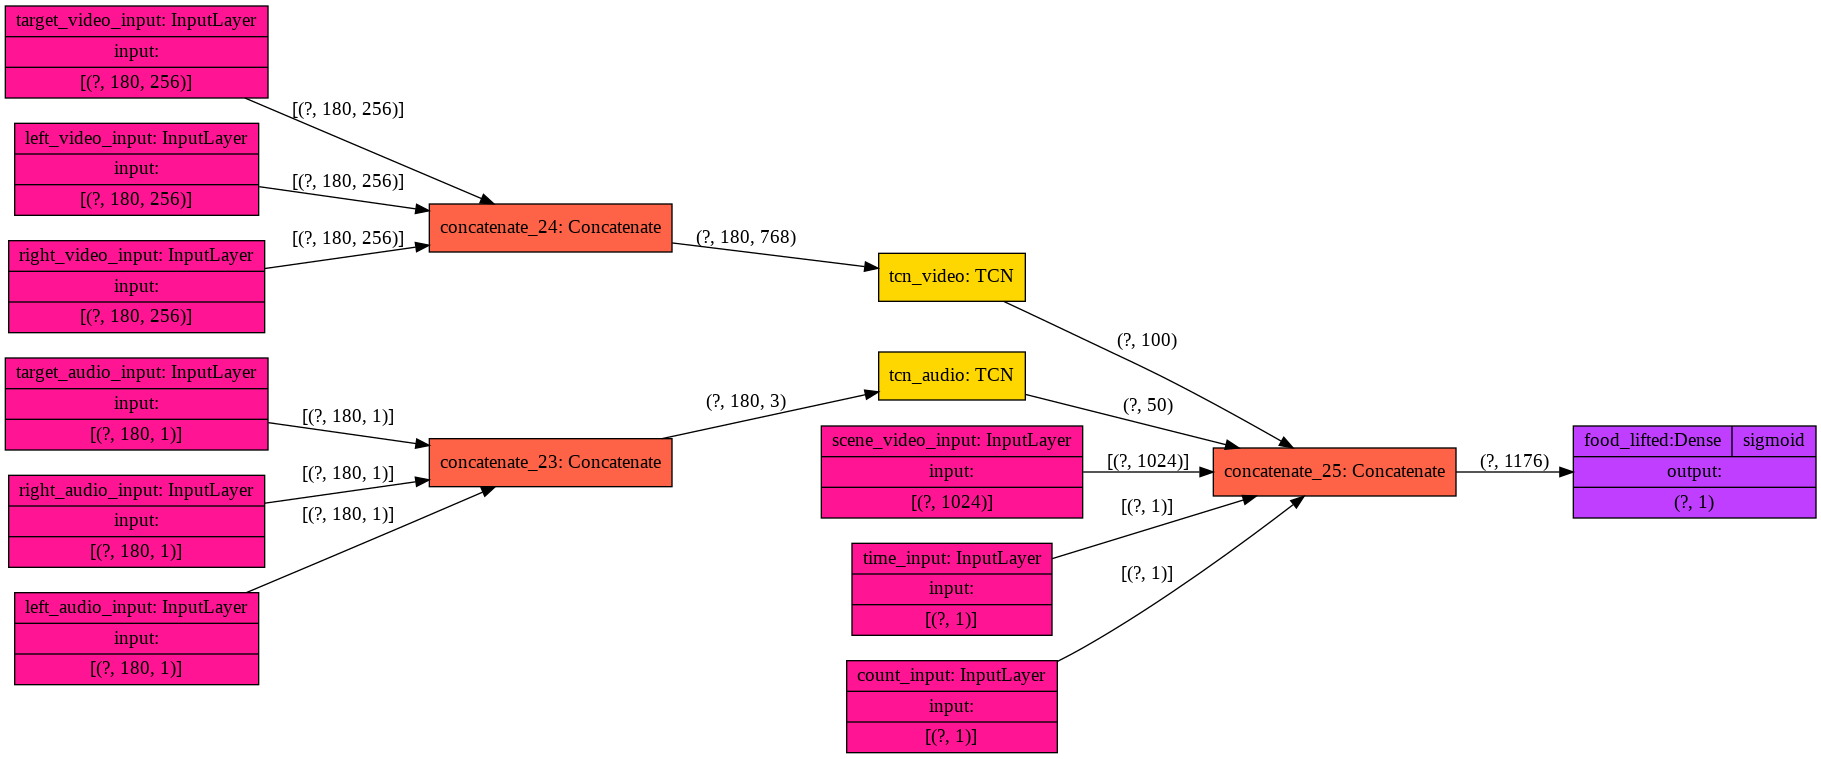

In [18]:
x_audio = concatenate([target_audio_input, left_audio_input, right_audio_input])
x_video = concatenate([target_video_input, left_video_input, right_video_input])

tcn_audio = TCN(
    nb_filters=50,             # The number of filters to use in the convolutional layers. Would be similar to units for LSTM. Can be a list.
    kernel_size=7,              # The size of the kernel to use in each convolutional layer.
    nb_stacks=1,                # The number of stacks of residual blocks to use.
    dilations=(1, 2, 4, 8),     # We want window_size (180) =< receptive_field (181) = 1 + 2*(kernel_size - 1)*nb_stacks*sum(dilations)
    padding='causal',           # Keep causal for a causal network
    use_skip_connections=True,
    dropout_rate=0.05,
    return_sequences=False,
    activation='relu',
    kernel_initializer='he_normal',
    use_batch_norm=False,
    use_layer_norm=False,
    use_weight_norm=False,
    name='tcn_audio'
)
tcn_video = TCN(
    nb_filters=100,             # The number of filters to use in the convolutional layers. Would be similar to units for LSTM. Can be a list.
    kernel_size=7,              # The size of the kernel to use in each convolutional layer.
    nb_stacks=1,                # The number of stacks of residual blocks to use.
    dilations=(1, 2, 4, 8),     # We want window_size (180) =< receptive_field (181) = 1 + 2*(kernel_size - 1)*nb_stacks*sum(dilations)
    padding='causal',           # Keep causal for a causal network
    use_skip_connections=True,
    dropout_rate=0.05,
    return_sequences=False,
    activation='relu',
    kernel_initializer='he_normal',
    use_batch_norm=False,
    use_layer_norm=False,
    use_weight_norm=False,
    name='tcn_video'
)
x = concatenate([ tcn_audio(x_audio), tcn_video(x_video), scene_video_input, time_input, count_input ])

outputs = Dense(1, activation='sigmoid', name='food_lifted')(x)
model = Model(inputs, outputs, name='TCN per-modality model')
model.summary()

# Plot
color_plot_model(model, rankdir='LR', show_shapes=True, show_layer_names=True, style=0)

# Model 3: per-modality sequence TCN

Model: "TCN per-modality model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 target_audio_input (InputLayer  [(None, 180, 1)]    0           []                               
 )                                                                                                
                                                                                                  
 left_audio_input (InputLayer)  [(None, 180, 1)]     0           []                               
                                                                                                  
 right_audio_input (InputLayer)  [(None, 180, 1)]    0           []                               
                                                                                                  
 target_video_input (InputLayer  [(None, 180, 256)]  0           []          

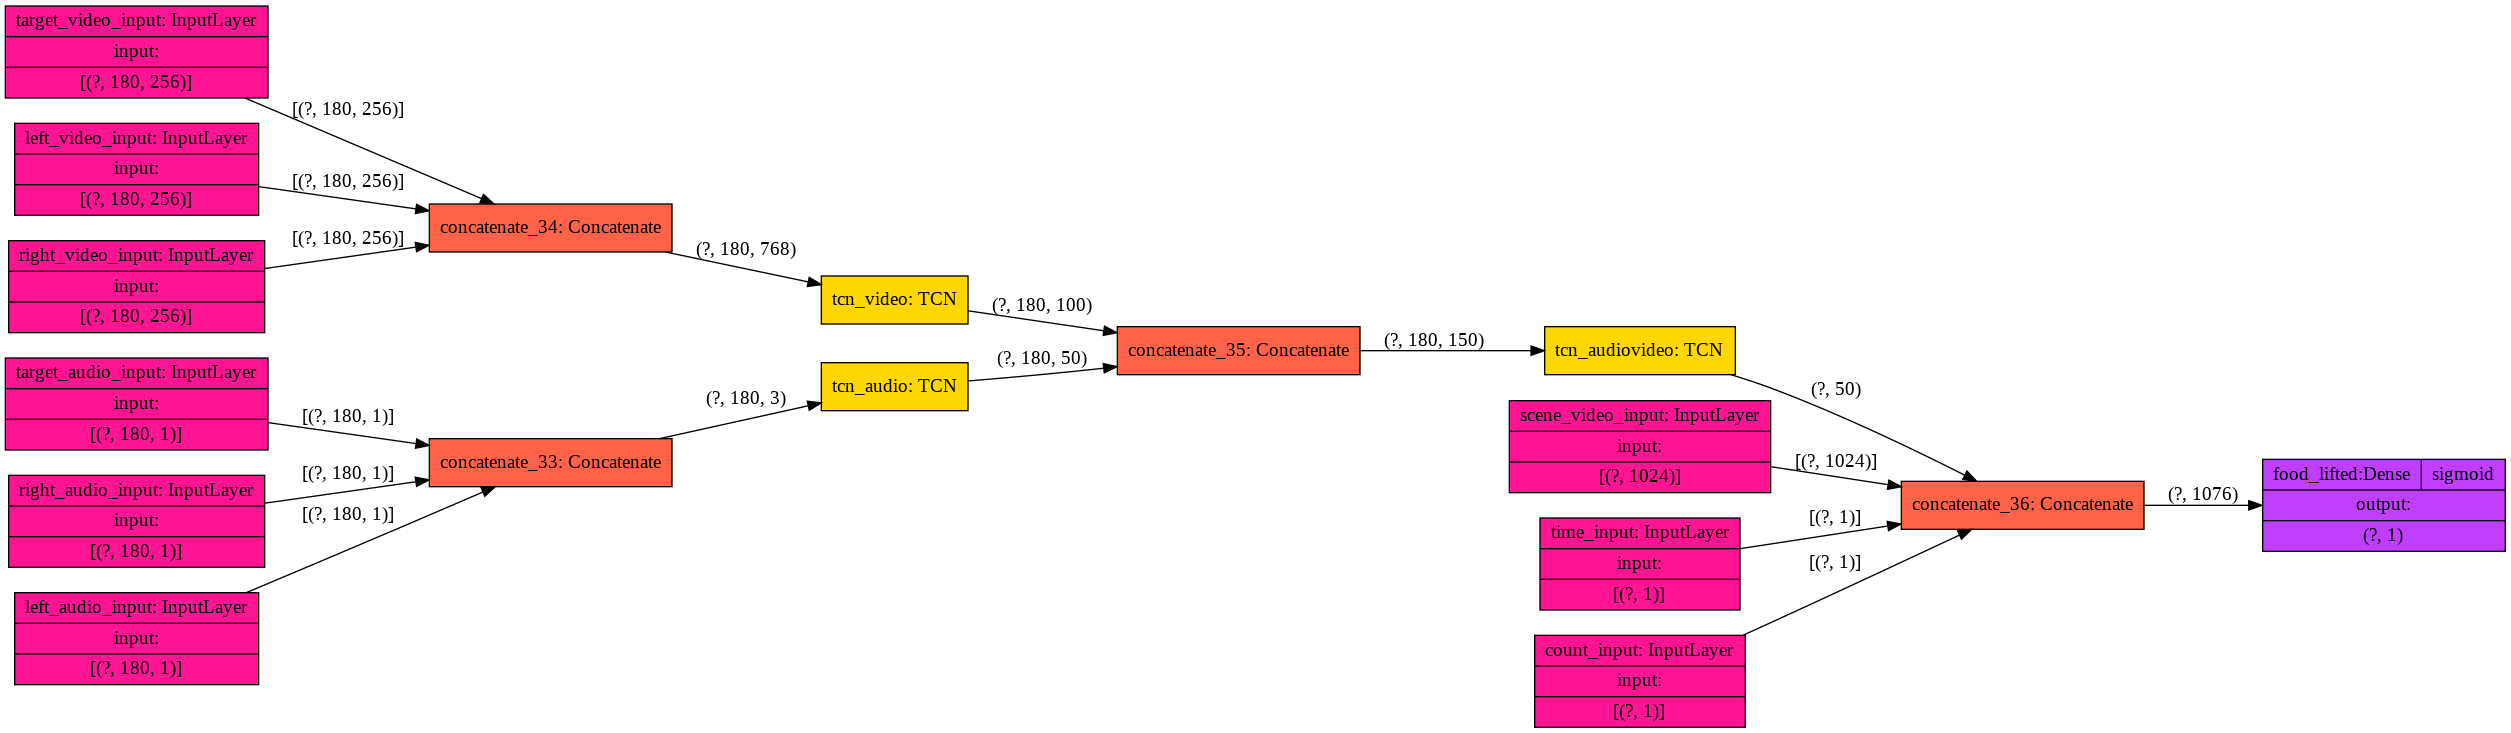

In [21]:
x_audio = concatenate([target_audio_input, left_audio_input, right_audio_input])
x_video = concatenate([target_video_input, left_video_input, right_video_input])

tcn_audio = TCN(
    nb_filters=50,             # The number of filters to use in the convolutional layers. Would be similar to units for LSTM. Can be a list.
    kernel_size=7,              # The size of the kernel to use in each convolutional layer.
    nb_stacks=1,                # The number of stacks of residual blocks to use.
    dilations=(1, 2, 4, 8),     # We want window_size (180) =< receptive_field (181) = 1 + 2*(kernel_size - 1)*nb_stacks*sum(dilations)
    padding='causal',           # Keep causal for a causal network
    use_skip_connections=True,
    dropout_rate=0.05,
    return_sequences=True,
    activation='relu',
    kernel_initializer='he_normal',
    use_batch_norm=False,
    use_layer_norm=False,
    use_weight_norm=False,
    name='tcn_audio'
)
tcn_video = TCN(
    nb_filters=100,             # The number of filters to use in the convolutional layers. Would be similar to units for LSTM. Can be a list.
    kernel_size=7,              # The size of the kernel to use in each convolutional layer.
    nb_stacks=1,                # The number of stacks of residual blocks to use.
    dilations=(1, 2, 4, 8),     # We want window_size (180) =< receptive_field (181) = 1 + 2*(kernel_size - 1)*nb_stacks*sum(dilations)
    padding='causal',           # Keep causal for a causal network
    use_skip_connections=True,
    dropout_rate=0.05,
    return_sequences=True,
    activation='relu',
    kernel_initializer='he_normal',
    use_batch_norm=False,
    use_layer_norm=False,
    use_weight_norm=False,
    name='tcn_video'
)
tcn_audiovideo = TCN(
    nb_filters=50,              # The number of filters to use in the convolutional layers. Would be similar to units for LSTM. Can be a list.
    kernel_size=7,              # The size of the kernel to use in each convolutional layer.
    nb_stacks=1,                # The number of stacks of residual blocks to use.
    dilations=(1, 2, 4, 8),     # We want window_size (180) =< receptive_field (181) = 1 + 2*(kernel_size - 1)*nb_stacks*sum(dilations)
    padding='causal',           # Keep causal for a causal network
    use_skip_connections=True,
    dropout_rate=0.05,
    return_sequences=False,
    activation='relu',
    kernel_initializer='he_normal',
    use_batch_norm=False,
    use_layer_norm=False,
    use_weight_norm=False,
    name='tcn_audiovideo'
)
x = tcn_audiovideo( concatenate([ tcn_audio(x_audio), tcn_video(x_video) ]) )
x = concatenate([ x, scene_video_input, time_input, count_input ])

outputs = Dense(1, activation='sigmoid', name='food_lifted')(x)
model = Model(inputs, outputs, name='TCN per-modality model')
model.summary()

# Plot
color_plot_model(model, rankdir='LR', show_shapes=True, show_layer_names=True, style=0)